In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# get a list of all the colour strings in matplotlib so we can iterate through them
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colour_list = list(colors.keys())

In [286]:
class IterationData:
    """
    A class to load in the data from each iteration to an object in a readable form for later visualisation    
    """
    def __init__(self, iteration, folder_path):

        self.training_path = folder_path + 'TrainingExamples' + str(iteration)
        self.nnet_loss_path = folder_path + 'NNetLosses' + str(iteration)
        
        # data formatting
        self.decimal_places = 3
        self.csv_rows = 5
        
        # data manipulation
        self.x_threshold = 2.4
        self.theta_threshold_radians = 0.21
        
        # define a useful class for training examples, so we can access dict memebers as .'key' rather than ['key']
        class ReturnClass(dict):
            def __getattr__(self, name):
                return self[name]
        
        # just get the number of episodes (need to do this before adding episodes to the dict annoyingly)
        with open(self.training_path + '.csv', 'r', newline='') as f:
            row_count = sum(1 for row in f)
        self.episodes = int(row_count/self.csv_rows)
        
        # read in training examples data and nnet loss data
        # dict of {ep1: dataframe[2Dstate, TrueValue, PolicyValue, MCTSAction, PolicyAction, Observation], ep2: ...}
        self.episode_training_data = ReturnClass()  
        self.state_2ds = np.load(self.training_path +'.npz')
        self.read_examples()
        self.nnet_losses = self.read_nnet_losses()
    
    def read_examples(self):
        step_counter = 0
        for episode in range(self.episodes):
            
            rows = [self.csv_rows*episode, self.csv_rows*episode+1, self.csv_rows*episode+2, self.csv_rows*episode+3, self.csv_rows*episode+4]

            # only pick out relevent rows (because others are different lengths -> can't be read)
            episode_data = pd.read_csv(self.training_path + '.csv', header=None, skiprows=lambda x: x not in rows).transpose()
            episode_data.columns = ['TrueValue', 'PolicyValue', 'MCTSAction', 'PolicyAction', 'Observation']
            episode_data.TrueValue = episode_data.TrueValue.astype(float).round(self.decimal_places)
            episode_data.PolicyValue = episode_data.PolicyValue.astype(float).round(self.decimal_places)

            # Split arrays and convert to floats
            episode_data.MCTSAction = episode_data.MCTSAction.apply(lambda x: x[1:-1].split(', '))
            episode_data.MCTSAction = episode_data.MCTSAction.apply(lambda x: [round(float(elm), self.decimal_places) for elm in x])
            
            episode_data.PolicyAction = episode_data.PolicyAction.apply(lambda x: x[1:-1].split(', '))
            episode_data.PolicyAction = episode_data.PolicyAction.apply(lambda x: [round(float(elm), self.decimal_places) for elm in x])
            
            episode_data.Observation = episode_data.Observation.apply(lambda x: x[1:-1].split())
            episode_data.Observation = episode_data.Observation.apply(lambda x: [round(float(elm), self.decimal_places) for elm in x])

            # if we want extra columns then this is the way to seperate the arr
            # print(list(zip(*dataframe.MCTSAction.values)))            
            
            # add a reference to the stated2D for each step
            episode_states = list(self.state_2ds)[step_counter:step_counter+episode_data.index[-1]+1]
            step_counter += episode_data.index[-1]+1          
            episode_data['State2D'] = episode_states
            
            # and then add the whole dataframe to the dict
            self.episode_training_data['Episode'+str(episode)] = episode_data
        
    def read_nnet_losses(self):
        losses = pd.read_csv(self.nnet_loss_path + '.csv', names=['Action', 'Value', 'Total'])
        return losses
    
    def get_state_2d(self, episode, step):
        episode = 'Episode'+str(episode)
        return self.state_2ds[self.episode_training_data[episode].State2D.values[step]]
    
    def get_episode_length(self, episode):
        episode = 'Episode'+str(episode)
        return self.episode_training_data[episode].index[-1]
        
    def plot_state_2d(self, state_2d):
        # Plot MCTS action, action policy and values associated?
        fig = plt.figure()
        axes = fig.add_axes([0, 0, 1, 1])  # add an axis object to the figure
        
        # returns a colourAxisImage, that we need to map the colourbar to the figure
        mapable = axes.imshow(state_2d, extent=[-self.x_threshold, self.x_threshold, -self.theta_threshold_radians,
                                     self.theta_threshold_radians], cmap='jet', aspect='auto')
        axes.set_xlabel("X-Position")
        axes.set_ylabel("Angular Position")
        axes.set_title('The 2D State')
    
    def get_action_image(self, prob_array, axes, title='Left', vs=(0.2, 0.5)):
        
        image = axes.imshow(prob_array, vmin = vs[0], vmax=vs[1], 
                            extent=[-self.x_threshold, self.x_threshold, -self.theta_threshold_radians, self.theta_threshold_radians], 
                            cmap='jet', aspect='auto')
        axes.set_xlabel("X-Position")
        axes.set_ylabel("Angular Position")
        axes.set_title(title+' probability vs Position')
        return axes, image
    
    def plot_episode_values(self, episode, colour = 'blue', fig_axes=None):
        # extract data for values and actions
        policy_values = self.episode_training_data['Episode'+str(episode)].PolicyValue
        true_values = self.episode_training_data['Episode'+str(episode)].TrueValue
        
        # check if subplots already exist
        if fig_axes is None:
            fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(17, 7))
        else:
            fig, axes = fig_axes[0], fig_axes[1]
            
        # Value Subplot
        axes.plot(policy_values, color=colour, linestyle='--', label='Policy Values Ep: '+str(episode))
        axes.plot(true_values, color=colour, linestyle='-', label='True Values Ep: '+str(episode))
        axes.legend()
        axes.set_ylabel('State Value')
        
        return fig, axes
    
    def plot_episode_actions(self, episode, actions=['left', 'do_nothing', 'right'], colour = 'blue', fig_axes=None):
        
        policy_actions = self.episode_training_data['Episode'+str(episode)].PolicyAction.values
        mcts_actions = self.episode_training_data['Episode'+str(episode)].MCTSAction.values
        policy_actions = list(zip(*policy_actions))
        mcts_actions = list(zip(*mcts_actions))        

        # check if subplots already exist
        if fig_axes is None:
            fig, axes = plt.subplots(ncols=1, nrows=len(actions), figsize=(17, len(actions)*7))
        else:
            fig, axes = fig_axes[0], fig_axes[1]
        
        possible_actions = {'left':0, 'do_nothing':1, 'right':2}
        if len(actions) > 1:
            for idx, action in enumerate(actions):
                axes[idx].plot(policy_actions[possible_actions[action]], color=colour, linestyle='--', label='Policy Actions Ep: '+str(episode))
                axes[idx].plot(mcts_actions[possible_actions[action]], color=colour, linestyle='-', label='MCTS Actions Ep: '+str(episode))
                axes[idx].legend()
                axes[idx].set_ylabel(action+' probability')
                axes[idx].set_xlabel('Steps')
        else:
            action = actions[0]
            axes.plot(policy_actions[possible_actions[action]], color=colour, linestyle='--', label='Policy Actions Ep: '+str(episode))
            axes.plot(mcts_actions[possible_actions[action]], color=colour, linestyle='-', label='MCTS Actions Ep: '+str(episode))
            axes.legend()
            axes.set_ylabel(action+' probability')
            axes.set_xlabel('Steps')
            
        
        return fig, axes
        
    def iteration_stepwise_value_stats(self, plot_all_eps=False):
        plt.figure(figsize=(17, 7))
        averages = -1*np.ones((200+1, ))
        deviations = np.zeros((200+1, ))
        # print(averages.head())
        for i in range(self.episodes):
            true_values = self.episode_training_data['Episode'+str(i)].TrueValue  # TrueValue or PolicyValue
            if plot_all_eps:
                plt.plot(true_values, linestyle=':')
            
            x = len(true_values)
            averages[0:x] += true_values
            averages[x:] += -1
            deviations[0:x] += true_values**2
            deviations[x:] += 1
        
        averages = averages/self.episodes
        deviations = np.sqrt(deviations - averages**2)/self.episodes  # to get the standard deviation
        return averages, deviations
    
    def calculate_action_vs_state_prob(self, x_dot_fixed=0, theta_dot_fixed=0, bin_proportion=0.05):
        shape = self.get_state_2d(episode=0, step=0).shape
        
        x_dot_bin_size = bin_proportion/self.x_threshold # either side of the value
        theta_dot_bin_size = bin_proportion/self.theta_threshold_radians # either side of the value
        
        # currently 3 actions
        left = np.zeros(shape, dtype=float)
        left_counter = np.zeros(shape, dtype=float)
        do_nothing = np.zeros(shape, dtype=float)
        do_nothing_counter = np.zeros(shape, dtype=float)
        right = np.zeros(shape, dtype=float)
        right_counter = np.zeros(shape, dtype=float)
        
        for ep in range(self.episodes):
            policy_actions = self.episode_training_data['Episode'+str(ep)].PolicyAction.values
            observation = self.episode_training_data['Episode'+str(ep)].Observation.values
            
            for s in range(self.get_episode_length(ep)):
                
                is_near_x_dot = (observation[s][1] > x_dot_fixed - x_dot_bin_size) and (observation[s][1] < x_dot_fixed + x_dot_bin_size)
                is_near_theta_dot = (observation[s][3] > theta_dot_fixed - theta_dot_bin_size) and (observation[s][3] < theta_dot_fixed + theta_dot_bin_size)
                
                if is_near_x_dot and is_near_theta_dot:
                    state_2d = self.get_state_2d(episode=ep, step=s)
                    row, column = np.unravel_index(np.argmax(state_2d, axis=None), shape) # get the index of the current element

                    left[row, column] += policy_actions[s][0]
                    left_counter[row, column] += 1
                    
                    do_nothing[row, column] += policy_actions[s][1]
                    do_nothing_counter[row, column] += 1
                    
                    right[row, column] += policy_actions[s][2]
                    right_counter[row, column] += 1
        
        prob_left = np.true_divide(left, left_counter)
        prob_nothing = np.true_divide(do_nothing, do_nothing_counter)
        prob_right = np.true_divide(right, right_counter)
        
        return (prob_left, prob_nothing, prob_right)
    
    def histogram_observations(self, normalised=True):
        
        # loop through all episodes to extract the observations
        all_observations = []
        for ep in range(self.episodes):
            all_observations.extend(self.episode_training_data['Episode'+str(ep)].Observation.values)
            
        # normalise all the observations
        if normalised:
            all_normed_observations = []
            for step in all_observations:
                obs = [step[0]/self.x_threshold,
                        step[1]/self.x_threshold,
                        step[2]/self.theta_threshold_radians,
                        step[3]/self.theta_threshold_radians,
                        ]
                all_normed_observations.append(obs)
            all_observations = all_normed_observations
        # flip the dimensions
        all_observations = list(zip(*all_observations))
        
        # Plot histograms
        fig, axes = plt.subplots(ncols=len(all_observations), nrows=1, figsize=(len(all_observations)*5, 5))
        obs_label = ['x', '$\dot{x}$', '$\\theta$', '$\dot{\\theta}$']
        axes[0].set_ylabel('Probability of Observation')
        for dim in range(len(all_observations)):
            axes[dim].hist(all_observations[dim], bins=20, density=True, color=colour_list[dim], alpha=0.9)
            if normalised:
                axes[dim].set_xlabel('Normalised '+obs_label[dim])
            else:
                axes[dim].set_xlabel(obs_label[dim])
            

In [287]:
class VisualiseData:
    """
    Uses objects of IterationData, which have building-block functions associated with them to more complexly visualise
    The data from each iteration and compare iterations.
    Attribute/Data Structure:
        
        self.iter_training_data = [IterationData(0), ..., IterationData(n)]
        
        IterationData:
            self.episodes = episodes in an iteration
            self.state_2ds = USE "get_state2d()" INSTEAD... list of state_2ds for an iteration
            self.nnet_losses = Dataframe with ['Action', 'Value', 'Total'] as the column headders
            self.episode_training_data = A Dictionary of episodes with keys ['EpisodeN'] where N is an int.
                    Each episode's value is a pandas dataframe with columns:
                    
                    ['TrueValue', 'PolicyValue', 'MCTSAction', 'PolicyAction',      'Observation',      'State2D']
                      [ float,      float,         [f, f, f],     [f, f, f],  [x, xdot, theta, thetadot], 'arr_n']
        
    Building-Block Functions:
    
        plot_nnet_losses(self):
                returns: none, plots the action, value and total loss for an iteration
                
        get_state_2d(self, episode, step):
                returns: the state 2D for the episode and step (since it it stored outside the dataframe)
        
        get_episode_length(self, episode):
                returns: the episode length for an episode in an iteration
    
        calculate_action_vs_state_prob(self, x_dot_fixed=0, theta_dot_fixed=0, bin_proportion=0.5):
                returns: 3 2d numpy arrays of p(a = ['left', 'do_nothing', 'right'] | xdot, thetadot, bin_size)
        
        iteration_stepwise_value_stats(self, plot_all_eps=False):
                returns: stepwise Value mean and std over all episodes in an iteration (optionally plot all episodes from iter)
                
        plot_episode_values(self, episode, colour = 'blue', fig_axes=None):
                returns: fig, axes so that we can plot more episodes on top, or plot from other iters
                
        plot_episode_actions(self, episode, actions=['left', 'do_nothing', 'right'], colour = 'blue', fig_axes=None):
                returns: fig, axes so that we can plot more episodes on top, or plot from other iters 
                
        plot_state_2d(self, state_2d):
                returns: plots the 2d state
                
        def get_action_image(self, prob_array, fig_ax, title='Left', vs=(0.2,0.5)):
                returns: fig, axes, image... takes an axes and plots the action-prob for that axis. image is for colourbar
                
        histogram_observations(self):
                returns: plots 4 histograms of the normalised observations
    """
    
    def __init__(self, data_set_path):
        
        # self.folder_path = os.path.join('..\ArchivedData', 'WhyNNETdoesntworkRes', '3Actions\\')
        self.folder_path = os.path.join('..\ArchivedData', 'WhyNNETdoesntworkConv', '3Actions\\')
        # self.folder_path = r'Data\\'
        
        self.iter_training_data = []
        self.iterations = 0
        while True:
            try:
                self.iter_training_data.append(IterationData(self.iterations, self.folder_path))
            except:
                break
            self.iterations += 1
        print("There are ", self.iterations, " iterations stored in self.iterations")
        
    def plot_action_vs_state(self, iters=[0, 1, 2], x_dot_fixed=0, theta_dot_fixed=0, bin_prop=0.05):
        assert all(i < self.iterations for i in iters), "Some iterations are not valid!"
        
        for itr in iters:
            left, nothing, right = self.iter_training_data[itr].calculate_action_vs_state_prob(x_dot_fixed, theta_dot_fixed, bin_prop)

            # Plot the things
            fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(17, 5), sharey=True)
            ax, im = self.iter_training_data[itr].get_action_image(left, axes[0], 'Left')
            ax, im = self.iter_training_data[itr].get_action_image(nothing, axes[1], 'Nothing')
            ax, im = self.iter_training_data[itr].get_action_image(right, axes[2], 'Right')
            fig.subplots_adjust(right=0.8)
            cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
            fig.colorbar(im, cax=cbar_ax)
            
    def plot_iter_values(self, iters=[0, 1, 2]):
        assert all(i < self.iterations for i in iters), "Some iterations are not valid!"
        
        fig = plt.figure(figsize=(17, 7))
        axes = fig.add_axes([0, 0, 1, 1])
        axes.set_xlabel('Steps')
        axes.set_ylabel('Average Value')
        axes.set_ylim([-1, 0])
        for itr in iters:
            means, std =self.iter_training_data[itr].iteration_stepwise_value_stats()
            
            axes.plot(means, linestyle='-', color=colour_list[itr], label='Itr:'+str(itr)+' Average Episode Value')
            axes.plot(means+std, linestyle='--', color=colour_list[itr])
            axes.plot(means-std, linestyle='--', color=colour_list[itr])
            axes.legend()
            
    def plot_iter_losses(self, iters=[0, 1, 2]):
        assert all(i < self.iterations for i in iters), "Some iterations are not valid!"
        
        fig = plt.figure(figsize=(17, 7))
        axes = fig.add_axes([0, 0, 1, 1])
        
        axes.set_xlabel('Batches (size 8)')
        axes.set_ylabel('Loss')
        
        for itr in iters:
            axes.plot(self.iter_training_data[itr].nnet_losses, label=['Itr '+str(itr)+' Action', 'Itr '+str(itr)+'Value', 'Itr '+str(itr)+'Total'])    
            axes.legend()
    
    def plot_observation_histograms(self, iters=[0, 1, 2], normed=True):
        for itr in iters:
            self.iter_training_data[itr].histogram_observations(normed)
            
        

In [288]:
# 9 base colours ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'aliceblue', 'antiquewhite', 'aqua'...

In [289]:
v = VisualiseData('a')
v.iter_training_data[0].episode_training_data['Episode0'].head()

There are  7  iterations stored in self.iterations


,TrueValue,PolicyValue,MCTSAction,PolicyAction,Observation,State2D
0,-0.015,-0.027,"[0.333, 0.333, 0.333]","[0.339, 0.334, 0.327]","[0.019, -0.035, 0.002, -0.036]",arr_0
1,-0.018,-0.032,"[0.29, 0.403, 0.306]","[0.338, 0.336, 0.326]","[0.018, -0.035, 0.002, -0.035]",arr_1
2,-0.022,-0.034,"[0.308, 0.333, 0.359]","[0.338, 0.336, 0.325]","[0.018, 0.16, 0.001, -0.327]",arr_2
3,-0.026,-0.027,"[0.333, 0.333, 0.333]","[0.339, 0.332, 0.329]","[0.021, 0.356, -0.006, -0.62]",arr_3
4,-0.030,-0.027,"[0.333, 0.333, 0.333]","[0.34, 0.332, 0.328]","[0.028, 0.356, -0.018, -0.621]",arr_4


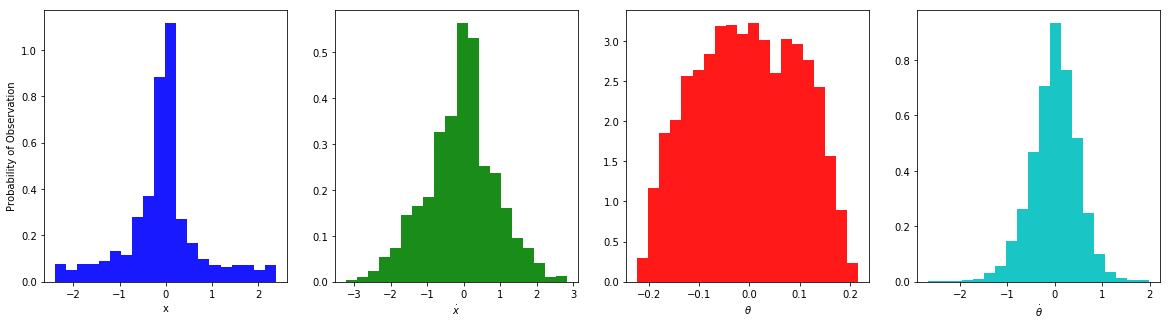

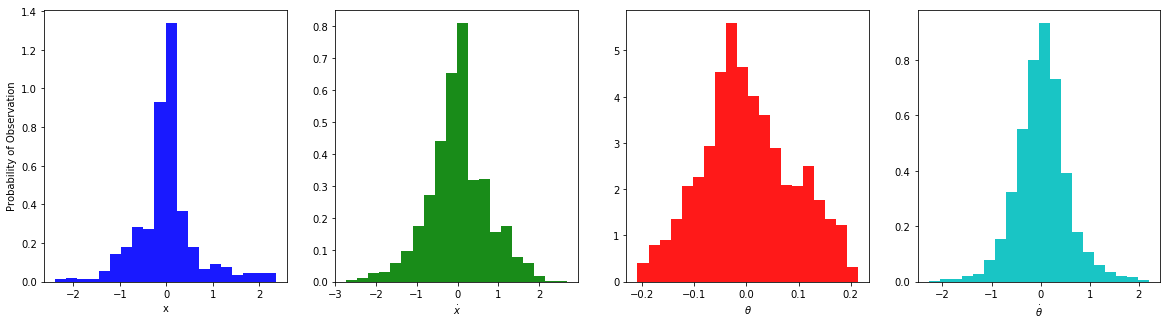

In [292]:
v.plot_observation_histograms(iters=[0, 1], normed=False)

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:218: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:219: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:220: RuntimeWarning: invalid value encountered in true_divide


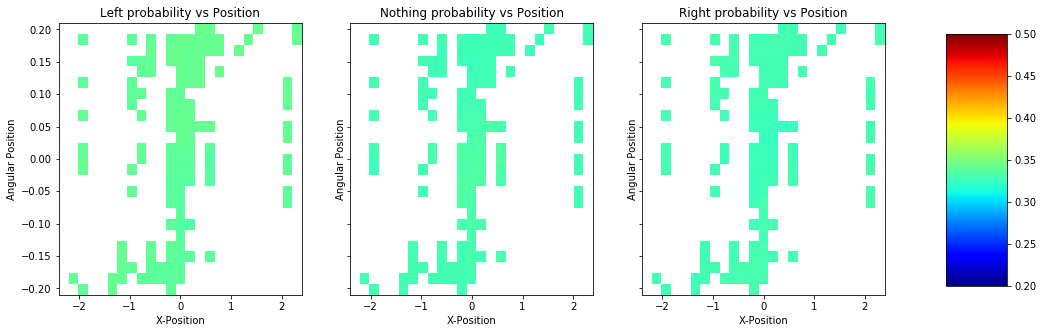

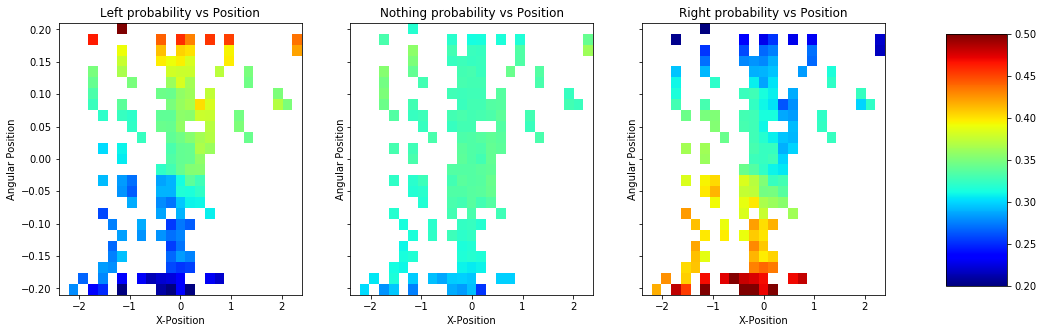

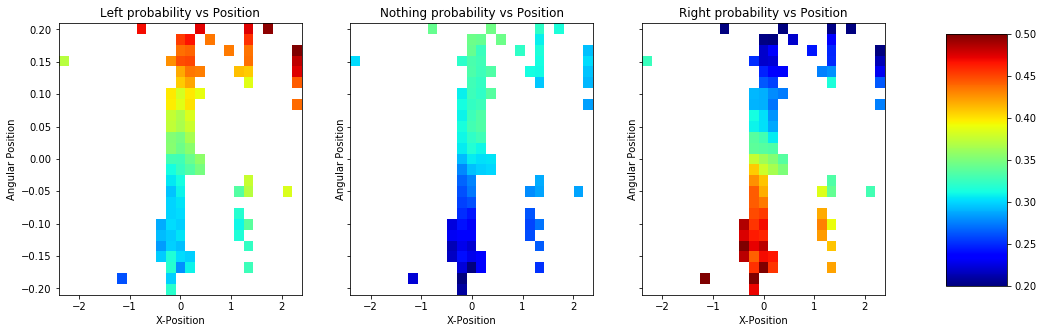

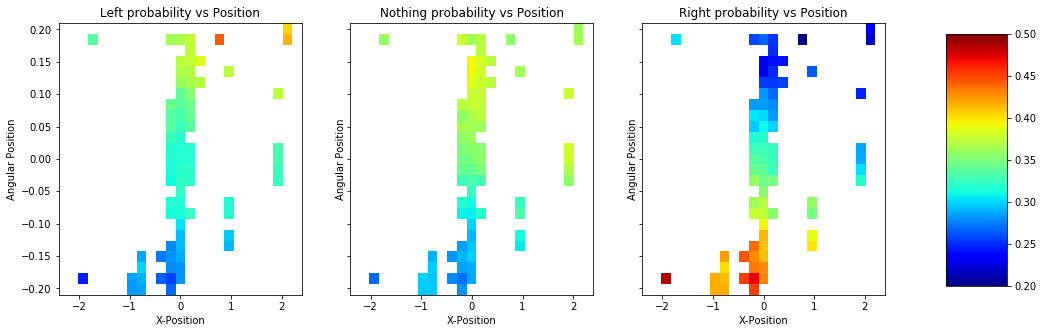

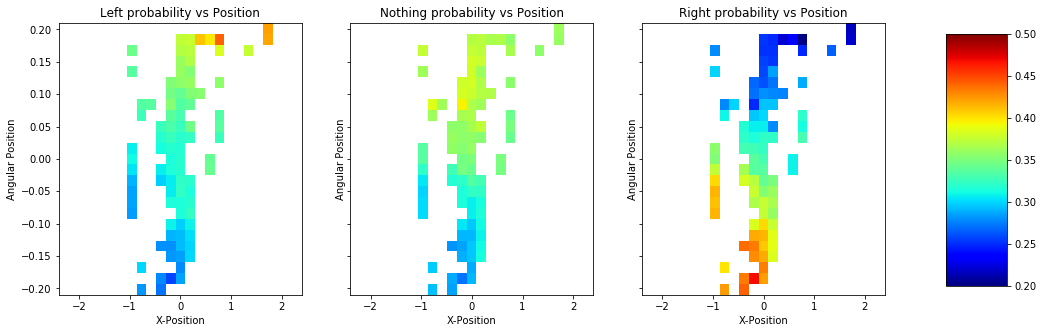

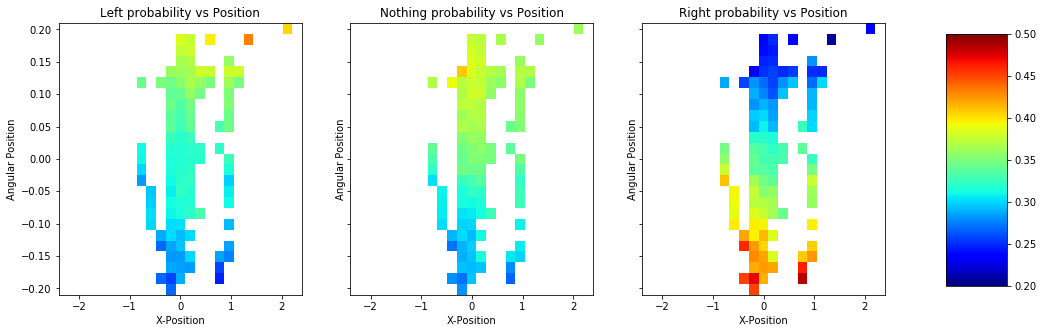

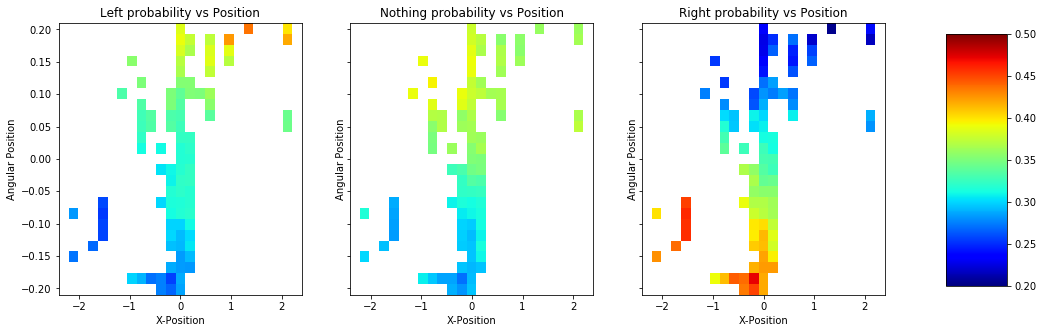

In [115]:
iters = [0, 1, 2, 3, 4, 5, 6]
v.plot_action_vs_state(iters, x_dot_fixed=0, theta_dot_fixed=0, bin_prop=0.1)

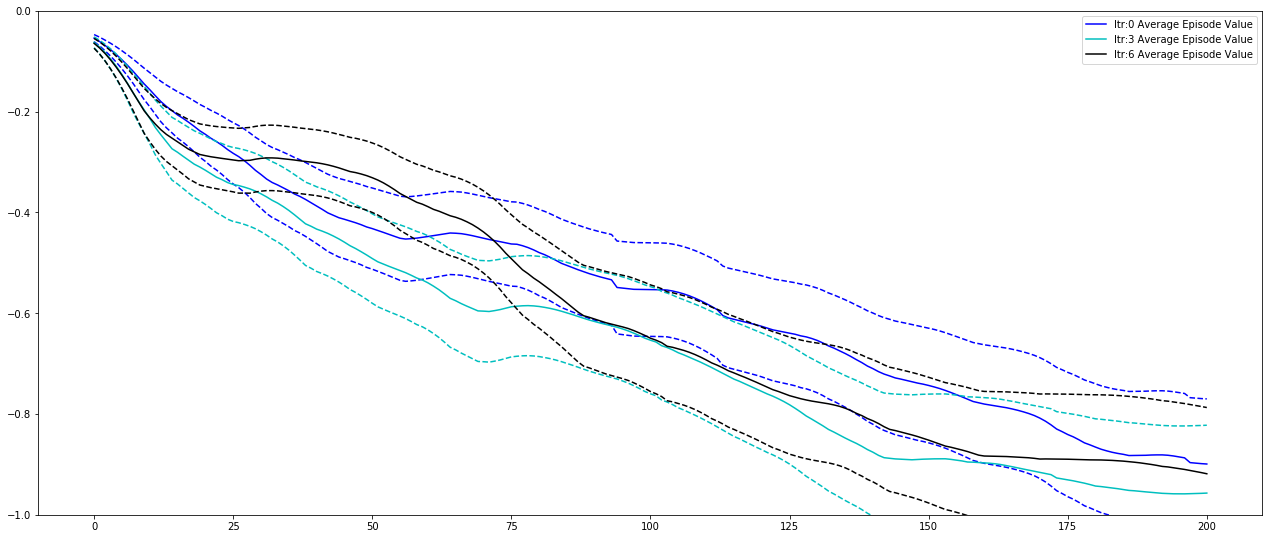

<Figure size 1224x504 with 0 Axes>

<Figure size 1224x504 with 0 Axes>

<Figure size 1224x504 with 0 Axes>

In [101]:
iters = [0, 3, 6]
v.plot_iter_values(iters)

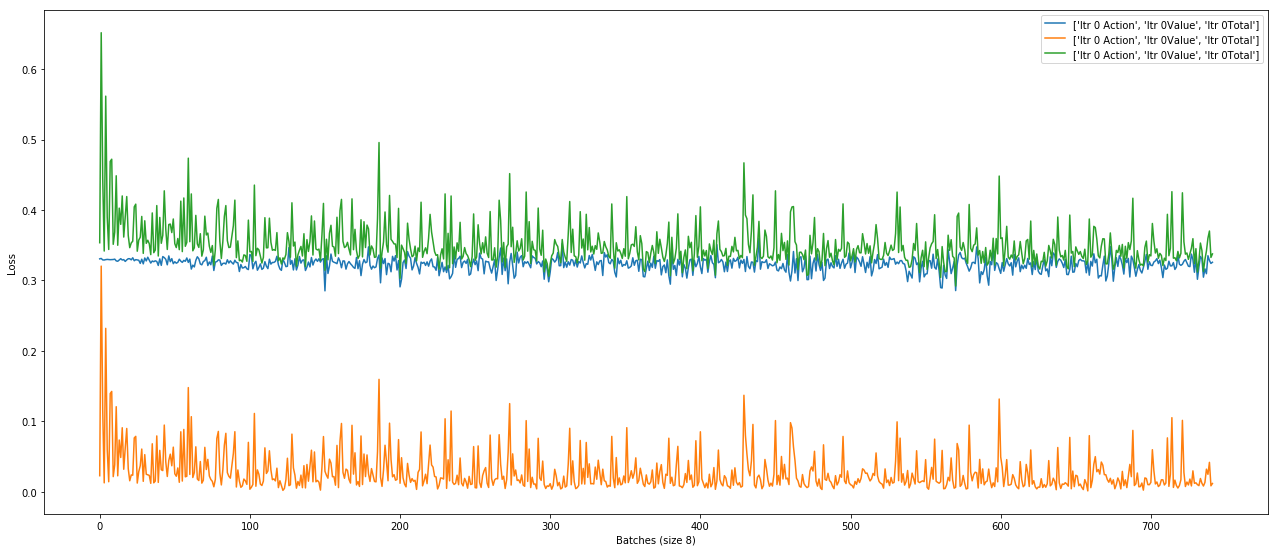

In [114]:
iters = [0]
v.plot_iter_losses(iters)

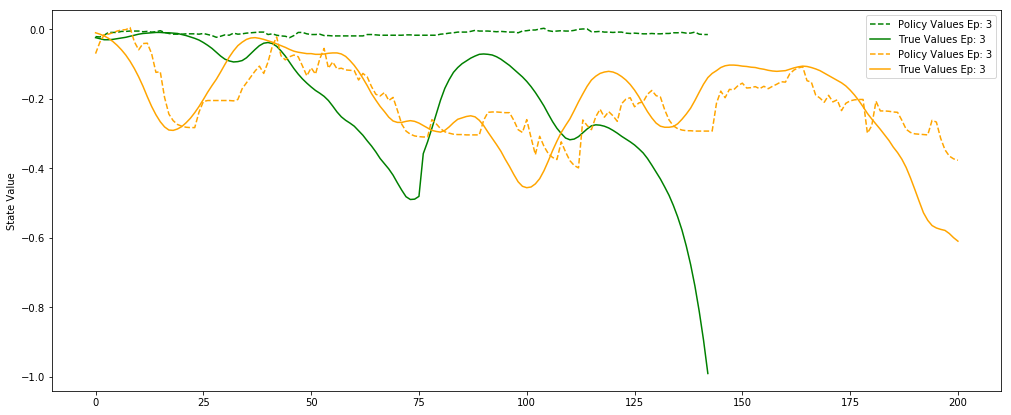

In [138]:
# fig, ax = te0.plot_episode(episode=3, colour='blue')
fig, ax = te0.plot_episode_values(episode=3, colour='green') #, fig_axes=(fig, ax))
fig_end, ax = te1.plot_episode_values(episode=3, colour='orange', fig_axes=(fig, ax))


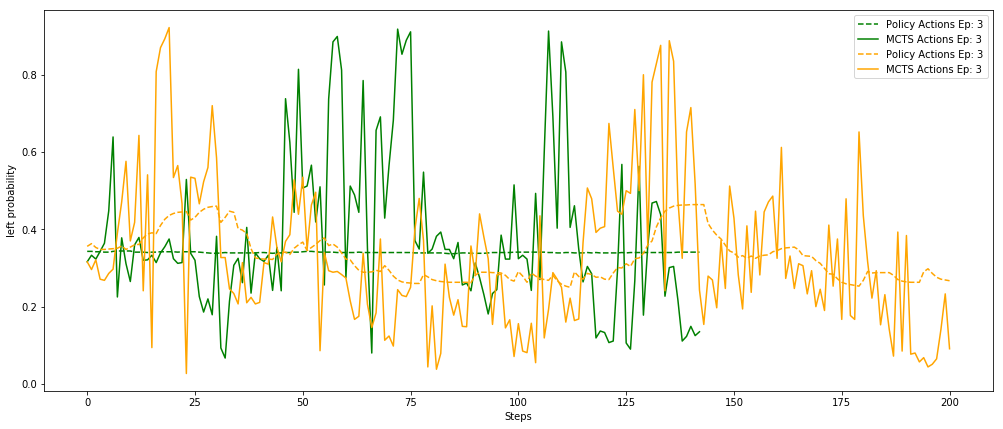

In [139]:
# fig, ax = te0.plot_episode(episode=3, colour='blue')
fig, ax = te0.plot_episode_actions(episode=3, actions=['left'], colour='green') #, fig_axes=(fig, ax))
fig_end, ax = te1.plot_episode_actions(episode=3, actions=['left'], colour='orange', fig_axes=(fig, ax))
